# NASDAQ 100 Prediction with World News

**Is it possible to predict the NDX stock's ups & downs with worldwide news?**

# Method 1 - using topics as inputs

## Data Collection

My data will be composed from:
1. **NDX** historical prices in a a span of 5 years from August 8th 2008 to July 1st 2016.
2. Top 25 posts from **r\worldnews** subreddit from August 8th 2008 to July 1st 2016.


In [91]:
#relevant libraries
from tqdm import tqdm
import datetime as dt
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import re
import string
import warnings
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import classification_report, plot_roc_curve
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
#warning hadle
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

## NDX historical prices

In [92]:
NDX = pd.read_csv("NDX.csv")
NDX["Stock_change"] =  np.where(NDX['Open']<= NDX['Adj Close'], "up", "down")
NDX.tail(6)

Date         Open         High          Low        Close  \
1983  2016-06-24  4294.799805  4373.149902  4274.540039  4285.700195   
1984  2016-06-27  4247.709961  4249.000000  4179.740234  4201.049805   
1985  2016-06-28  4245.319824  4291.430176  4245.290039  4290.470215   
1986  2016-06-29  4323.330078  4373.959961  4322.359863  4364.740234   
1987  2016-06-30  4378.750000  4417.959961  4359.569824  4417.700195   
1988  2016-07-01  4411.770020  4453.859863  4411.759766  4437.450195   

        Adj Close      Volume Stock_change  
1983  4285.700195  4411040000         down  
1984  4201.049805  2659650000         down  
1985  4290.470215  2074090000           up  
1986  4364.740234  2116550000           up  
1987  4417.700195  2171180000           up  
1988  4437.450195  1745130000           up

In [93]:
NDX.shape

(1989, 8)

## r/worldnews

In [94]:
r_news = pd.read_csv("r_news.csv")
r_news.drop("Unnamed: 0",axis = 1, inplace = True)
r_news.head()

Date                                               Top1  \
0  2008-08-08  b"Georgia 'downs two Russian warplanes' as cou...   
1  2008-08-11  b'Why wont America and Nato help us? If they w...   
2  2008-08-12  b'Remember that adorable 9-year-old who sang a...   
3  2008-08-13  b' U.S. refuses Israel weapons to attack Iran:...   
4  2008-08-14  b'All the experts admit that we should legalis...   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1        b'Bush puts foot down on Georgian conflict'   
2                 b"Russia 'ends Georgia operation'"   
3  b"When the president ordered to attack Tskhinv...   
4  b'War in South Osetia - 89 pictures made by a ...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   
2  b'"If we had no sexual harassment we would hav...   
3  b' Israel clears troops who killed Reuters cam...   
4  b'Swedish wrestler Ara Abrahamian throws away ...   

                                                Top4  \
0  b'Russian tanks are moving towards the capital...   
1  b'Georgian army flees in disarray as Russians ...   
2  b"Al-Qa'eda is losing support in Iraq because ...   
3  b'Britain\'s policy of being tough on drugs is...   
4  b'Russia exaggerated the death toll in South O...   

                                                Top5  \
0  b"Afghan children raped with 'impunity,' U.N. ...   
1      b"Olympic opening ceremony fireworks 'faked'"   
2  b'Ceasefire in Georgia: Putin Outmaneuvers the...   
3  b'Body of 14 year old found in trunk; Latest (...   
4  b'Missile That Killed 9 Inside Pakistan May Ha...   

                                                Top6  \
0  b'150 Russian tanks have entered South Ossetia...   
1  b'What were the Mossad with fraudulent New Zea...   
2  b'Why Microsoft and Intel tried to kill the XO...   
3  b'China has moved 10 *million* quake survivors...   
4  b"Rushdie Condemns Random House's Refusal to P...   

                                                Top7  \
0  b"Breaking: Georgia invades South Ossetia, Rus...   
1  b'Russia angered by Israeli military sale to G...   
2  b'Stratfor: The Russo-Georgian War and the Bal...   
3  b"Bush announces Operation Get All Up In Russi...   
4  b'Poland and US agree to missle defense deal. ...   

                                                Top8  \
0  b"The 'enemy combatent' trials are nothing but...   
1  b'An American citizen living in S.Ossetia blam...   
2  b"I'm Trying to Get a Sense of This Whole Geor...   
3             b'Russian forces sink Georgian ships '   
4  b'Will the Russians conquer Tblisi? Bet on it,...   

                                                Top9  ...  \
0  b'Georgian troops retreat from S. Osettain cap...  ...   
1  b'Welcome To World War IV! Now In High Definit...  ...   
2  b"The US military was surprised by the timing ...  ...   
3  b"The commander of a Navy air reconnaissance s...  ...   
4  b'Russia exaggerating South Ossetian death tol...  ...   

                                               Top16  \
0  b'Georgia Invades South Ossetia - if Russia ge...   
1  b'Israel and the US behind the Georgian aggres...   
2  b'U.S. troops still in Georgia (did you know t...   
3                      b'Elephants extinct by 2020?'   
4  b'Bank analyst forecast Georgian crisis 2 days...   

                                               Top17  \
0                b'Al-Qaeda Faces Islamist Backlash'   
1  b'"Do not believe TV, neither Russian nor Geor...   
2       b'Why Russias response to Georgia was right'   
3  b'US humanitarian missions soon in Georgia - i...   
4  b"Georgia confict could set back Russia's US r...   

                                               Top18  \
0  b'Condoleezza Rice: "The US would not act to p...   
1  b'Riots are still going on in Montreal (Canada...   
2  b'Gorbachev accuses U.S. of m

In [95]:
#convert date to datetime
r_news["Date"] = pd.to_datetime(r_news["Date"])
r_news["Date"].head()

0   2008-08-08
1   2008-08-11
2   2008-08-12
3   2008-08-13
4   2008-08-14
Name: Date, dtype: datetime64[ns]

In [96]:
r_news.shape

(1989, 26)

## Combined dataset (Reddit + stock change)

In [97]:
#add the ndx trend (up/down)
r_news["Stock_change"] = NDX.iloc[:,-1].values
# remove the Date columns
r_news.set_index("Date",inplace = True)
r_news.head(10)

Top1  \
Date                                                            
2008-08-08  b"Georgia 'downs two Russian warplanes' as cou...   
2008-08-11  b'Why wont America and Nato help us? If they w...   
2008-08-12  b'Remember that adorable 9-year-old who sang a...   
2008-08-13  b' U.S. refuses Israel weapons to attack Iran:...   
2008-08-14  b'All the experts admit that we should legalis...   
2008-08-15  b"Mom of missing gay man: Too bad he's not a 2...   
2008-08-18  b'In an Afghan prison, the majority of female ...   
2008-08-19  b"Man arrested and locked up for five hours af...   
2008-08-20  b'Two elderly Chinese women have been sentence...   
2008-08-21  b"British resident held in Guantanamo Bay wins...   

                                                         Top2  \
Date                                                            
2008-08-08            b'BREAKING: Musharraf to be impeached.'   
2008-08-11        b'Bush puts foot down on Georgian conflict'   
2008-08-12                 b"Russia 'ends Georgia operation'"   
2008-08-13  b"When the president ordered to attack Tskhinv...   
2008-08-14  b'War in South Osetia - 89 pictures made by a ...   
2008-08-15  b"Russia: U.S. Poland Missile Deal Won't Go 'U...   
2008-08-18          b"Little girl, you're not ugly; they are"   
2008-08-19  b'The US missile defence system is the magic p...   
2008-08-20  b'The Power of Islam: The Human Rights Council...   
2008-08-21  b'Chinese may have killed 140 Tibetans this we...   

                                                         Top3  \
Date                                                            
2008-08-08  b'Russia Today: Columns of troops roll into So...   
2008-08-11  b"Jewish Georgian minister: Thanks to Israeli ...   
2008-08-12  b'"If we had no sexual harassment we would hav...   
2008-08-13  b' Israel clears troops who killed Reuters cam...   
2008-08-14  b'Swedish wrestler Ara Abrahamian throws away ...   
2008-08-15  b"The government has been accused of creating ...   
2008-08-18  b"Pakistan's Musharraf to Resign, Leave the Co...   
2008-08-19  b'Schrder lambasted for blaming Russian confli...   
2008-08-20  b"We had 55 times more military soldiers in th...   
2008-08-21                 b'U.S. Navy Ships Head to Georgia'   

                                                         Top4  \
Date                                                            
2008-08-08  b'Russian tanks are moving towards the capital...   
2008-08-11  b'Georgian army flees in disarray as Russians ...   
2008-08-12  b"Al-Qa'eda is losing support in Iraq because ...   
2008-08-13  b'Britain\'s policy of being tough on drugs is...   
2008-08-14  b'Russia exaggerated the death toll in South O...   
2008-08-15  b'The Italian government has lashed out at an ...   
2008-08-18  b'Tornado throws a bus in Poland, captured by ...   
2008-08-19  b'Officials: 10 French soldiers killed near Ka...   
2008-08-20  b'"I live here on less than a dollar a month" ...   
2008-08-21           b'Hacker uncovers Chinese olympic fraud'   

                                                         Top5  \
Date                                                            
2008-08-08  b"Afghan children raped with 'impunity,' U.N. ...   
2008-08-11      b"Olympic opening ceremony fireworks 'faked'"   
2008-08-12  b'Ceasefire in Georgia: Putin Outmaneuvers the...   
2008-08-13  b'Body of 14 year old found in trunk; Latest (...   
2008-08-14  b'Missile That Killed 9 Inside Pakistan May Ha...   
2008-08-15  b'Gorbachev: Georgia started conflict in S. Os...   
2008-08-18  b"Britain's terror laws have left me and my fa...   
2008-08-19  b'These ten laws make China a totalitarian was...   
2008-08-20         b'Russia sends aircraft carrier to Syria.'   
2008-08-21  b"If you've ever wondered what Kim Jong Il was...   

                                                         Top6  \
Date                                                            
2008-08-08  b'150 Russ

In [98]:
#train and test set
train = r_news[r_news.index<=pd.Timestamp('2014-12-31')]
test = r_news[r_news.index>pd.Timestamp('2014-12-31')]
print(f"train shape: {train.shape}\n test shape: {test.shape}")

train shape: (1611, 26)
 test shape: (378, 26)


## Data Cleaning

### fill missing values

the fill of missing values will be an empty string to hold the position of the missing value.

In [99]:
print(f"{train.info()}\n {test.info()}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1611 entries, 2008-08-08 to 2014-12-31
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Top1          1611 non-null   object
 1   Top2          1611 non-null   object
 2   Top3          1611 non-null   object
 3   Top4          1611 non-null   object
 4   Top5          1611 non-null   object
 5   Top6          1611 non-null   object
 6   Top7          1611 non-null   object
 7   Top8          1611 non-null   object
 8   Top9          1611 non-null   object
 9   Top10         1611 non-null   object
 10  Top11         1611 non-null   object
 11  Top12         1611 non-null   object
 12  Top13         1611 non-null   object
 13  Top14         1611 non-null   object
 14  Top15         1611 non-null   object
 15  Top16         1611 non-null   object
 16  Top17         1611 non-null   object
 17  Top18         1611 non-null   object
 18  Top19         1611 non-null   

In [100]:
print(f"before filling:\n\ttrain missing: {train.isna().sum().sum()}\n\t test missing: {test.isna().sum().sum()}\n\n")
train.fillna("", inplace=True)
print(f"after filling:\n\ttrain missing: {train.isna().sum().sum()}\n\t test missing: {test.isna().sum().sum()}\n\n")

before filling:
	train missing: 7
	 test missing: 0


after filling:
	train missing: 0
	 test missing: 0




### clean the text

The method for text cleaning:
1. A function for removing the initial "b"character if it exists.
2. A function that returns  if the token is "valid" or not (for invalid token removal).
3. A function that returns a token to it's lowercase lemmatizaed form.
4. A function combining all those functions.

all the functions implement the spacy's nlp object.

In [101]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

def no_b(text):
    '''remove the lower case b in the start of the headlines if it exists'''
    return text[1:] if text.startswith("b") else text

def is_token_allowed(token):
    '''
        Only allow valid tokens which are not stop words
        and punctuation symbols or numbers.
    '''
    if (not token or
        token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    """
    Reduce token to its lowercase lemmatizaed form
    """
    return token.lemma_.strip().lower()

def text_transformer(text):
    """
    combines all the operations above
    """
    doc = nlp(no_b(text))
    tokens = [preprocess_token(token) for token in doc if is_token_allowed(token)]
    return " ".join(tokens)

In [102]:
#after
text_transformer(train.loc[pd.Timestamp('2008-08-08'), 'Top1'])

'georgia down russian warplane country brink war'

In [103]:
tqdm.pandas() #spacy has a long running time, so mesurments are taken
#for every topic
for col in train.columns.tolist()[:25]:
    #clean the text using the operations we defined above
    train[col] = train[col].progress_apply(lambda x:text_transformer(x)) 
    test[col] = test[col].progress_apply(lambda x:text_transformer(x))

100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 142.90it/s]


In [104]:
train.sample(3).sort_index(ascending=True)

Top1  \
Date                                                            
2011-11-08  artist ai wei wei order pay fine 1.6 million e...   
2012-03-16  chinese official propose death penalty deterre...   
2013-07-12  canadians win $ 250,000 dollar prize human pow...   

                                                         Top2  \
Date                                                            
2011-11-08  sarkozy call netanyahu liar obama express disp...   
2012-03-16  new chevron oil leak coast brazil 5 month chev...   
2013-07-12  edward snowden call meet amnesty international...   

                                                         Top3  \
Date                                                            
2011-11-08  uk police right fire rubber bullet student pro...   
2012-03-16                     shell admit 207 oil spill 2011   
2013-07-12  russian lawmaker snowden deserve nobel peace p...   

                                                         Top4  \
Date                                                            
2011-11-08  group russian scientist come isolation chamber...   
2012-03-16  jewish man win fight german museum return thou...   
2013-07-12  snowden action plan mean harm want succeed ask...   

                                                         Top5  \
Date                                                            
2011-11-08  wikileaks founder abandon australian govt kevi...   
2012-03-16  uk help israel attack iran prime minister davi...   
2013-07-12  snowden watch todays moscow havana flight take...   

                                                         Top6  \
Date                                                            
2011-11-08                          hajj eid al adha 2011 pic   
2012-03-16  afghan president hamid karzai lash united stat...   
2013-07-12  telstra store datum behalf government datum te...   

                                                         Top7  \
Date                                                            
2011-11-08  sicilian mafia seven year old jail torture thr...   
2012-03-16  putin fabled tiger encounter pr stunt environm...   
2013-07-12  irish government pass legislation allow aborti...   

                                                         Top8  \
Date                                                            
2011-11-08                       silvio berlusconi vow resign   
2012-03-16  moroccans end rape marriage law africa al jaze...   
2013-07-12  amnesty international having see evidence imme...   

                                                         Top9  \
Date                                                            
2011-11-08    bbc news sarkozy call israeli pm netanyahu liar   
2012-03-16            friend egypts mp declare israel 1 enemy   
2013-07-12  happen minute minute live coverage snowden mee...   

                                                        Top10  ...  \
Date                                                           ...   
2011-11-08  bbc news italian crisis silvio berlusconi lose...  ...   
2012-03-16  email nuclear physicist europe celebrated labo...  ...   
2013-07-12  corrupt zimbabwe hospital charge woman labor $...  ...   

                                                        Top17  \
Date                                                            
2011-11-08  falun gong practitioner hold long silent prote...   
2012-03-16  expect light resurgent german debate willingne...   
2013-07-12          saudi princess post $ 5 million bail free   

                                                        Top18  \
Date                                                            
2011-11-08  mexican jail raid find  peacock 100 fighting c...   
2012-03-16  canada consider fate arctic explorer ship repa...   
2013-07-12  edward snowden meet human right group amnesty ...   

                                                        Top19  \
Date                                                   

## EDA
### Desciptive Statistics

In [105]:
train.describe(include = "object") #no relevant info

Top1  \
count                                              1611   
unique                                             1610   
top     monsanto uproot germany ban cultivation gm corn   
freq                                                  2   

                                                     Top2  \
count                                                1611   
unique                                               1611   
top     year old afghan girl wear suicide vest detain ...   
freq                                                    1   

                                           Top3  \
count                                      1611   
unique                                     1609   
top     success drug decriminalization portugal   
freq                                          2   

                                                     Top4  \
count                                                1611   
unique                                               1611   
top     turkey higher education loans dormitories inst...   
freq                                                    1   

                                   Top5                             Top6  \
count                              1611                             1611   
unique                             1611                             1610   
top     china censor mention rumor coup  delhi police woman deserve rape   
freq                                  1                                2   

                                                     Top7  \
count                                                1611   
unique                                               1611   
top     u.s. department energys national renewable ene...   
freq                                                    1   

                                                  Top8  \
count                                             1611   
unique                                            1611   
top     china accuse financial weapon mass destruction   
freq                                                 1   

                                                     Top9  \
count                                                1611   
unique                                               1611   
top     catholic church enslave 30,000 irish woman for...   
freq                                                    1   

                                                    Top10  ...  \
count                                                1611  ...   
unique                                               1611  ...   
top     google say china deliberately disrupt e mail s...  ...   
freq                                                    1  ...   

                                                    Top17  \
count                                                1611   
unique                                               1611   
top     pakistan parent kill daughter acid eye boy wor...   
freq                                                    1   

                                                    Top18  \
count                                                1611   
unique                                               1611   
top     voter iceland reject deal repay britain nether...   
freq                                                    1   

                                                    Top19  \
count                                                1611   
unique                                               1611   
top     south african national assembly pass protectio...   
freq                                                    1   

                                                    Top20  \
count                                                1611   
unique                                               1611   
top     80 year old catholic priest perth australia bi...   
freq                                                    1   

                                                

### Target varaible bar plot

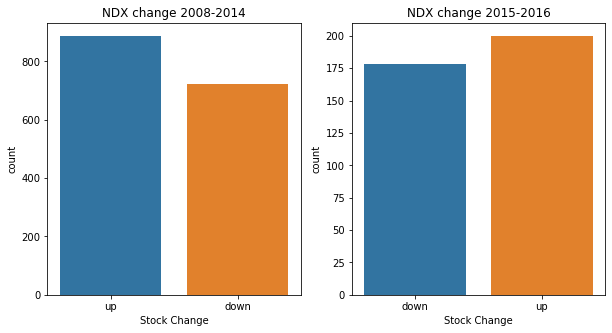

In [106]:
import seaborn as sns
f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (10,5))
#2008-2014
sns.countplot(train["Stock_change"], ax = axes[0])
axes[0].set_title("NDX change 2008-2014")
axes[0].set_xlabel("Stock Change")
#2015-2016
sns.countplot(test["Stock_change"],ax = axes[1])
axes[1].set_xlabel("Stock Change")
axes[1].set_title("NDX change 2015-2016");

### Character count

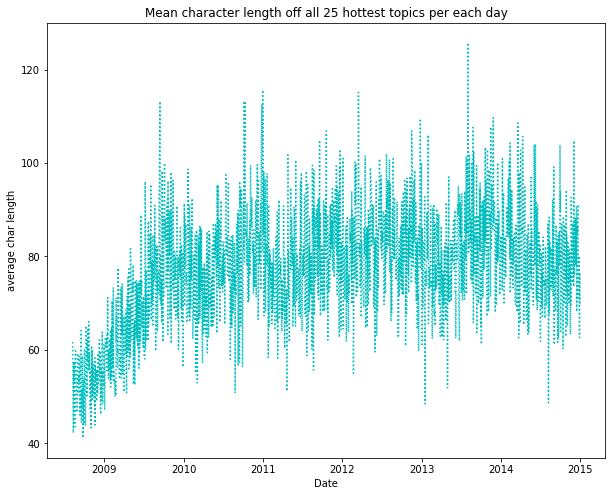

In [107]:
length = [] #empty list
for col in train.columns.tolist()[0:25]:#for all top 25 topics
    length.append(np.array(train[col].str.len().values.tolist())) #append to list each array of str lengths
mean_char = np.mean(length, axis = 0) #mean character length off all 25 hottest topics per each day
date = train.index# date
plt.figure(figsize = (10,8))
plt.ylabel("average char length")
plt.xlabel("Date")
plt.title("Mean character length off all 25 hottest topics per each day")
plt.plot(date, mean_char, 'c:', label='variance') 
plt.show()

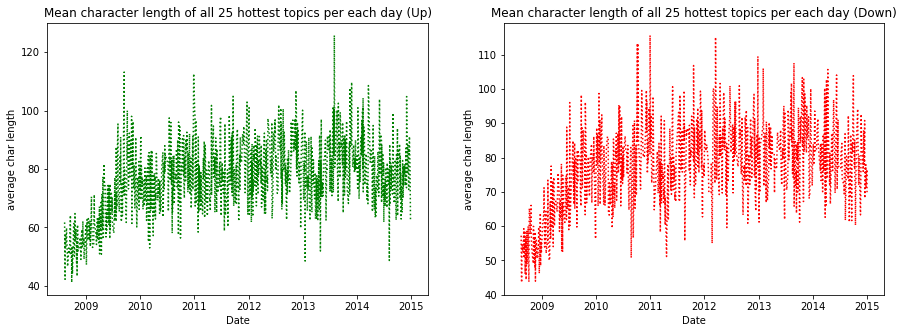

In [108]:
up = train[train["Stock_change"]=="up"]
length_up = [] #empty list
for col in up.columns.tolist()[0:25]:#for all top 25 topics
    length_up.append(np.array(up[col].str.len().values.tolist())) #append to list each array of str lengths
up_char = np.mean(length_up, axis = 0) #mean character length off all 25 hottest topics per each day

down = train[train["Stock_change"]=="down"]
length_down = [] #empty list
for col in down.columns.tolist()[0:25]:#for all top 25 topics
    length_down.append(np.array(down[col].str.len().values.tolist())) #append to list each array of str lengths
down_char = np.mean(length_down, axis = 0) #mean character length off all 25 hottest topics per each day

f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
axes[0].set_ylabel("average char length")
axes[0].set_xlabel("Date")
axes[0].set_title("Mean character length of all 25 hottest topics per each day (Up)")
axes[0].plot(up.index, up_char, 'g:')

axes[1].set_ylabel("average char length")
axes[1].set_xlabel("Date")
axes[1].set_title("Mean character length of all 25 hottest topics per each day (Down)")
axes[1].plot(down.index, down_char, 'r:');

### Word counts

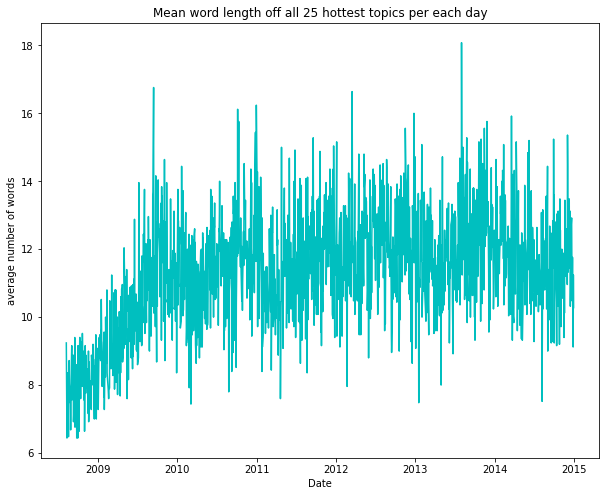

In [109]:
words_num = []
for col in train.columns.tolist()[:25]:
    words_num.append(np.array(train[col].apply(lambda w: len(w.split()))))
mean_word = np.mean(words_num, axis = 0)
date = train.index# date
plt.figure(figsize = (10,8))
plt.ylabel("average number of words")
plt.xlabel("Date")
plt.title("Mean word length off all 25 hottest topics per each day")
plt.plot(date, mean_word, 'c-', label='variance') 
plt.show()

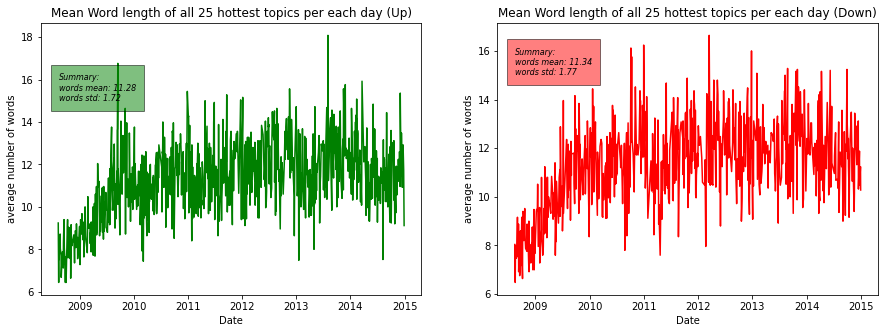

In [110]:
wl_up = [] #word length
for col in up.columns.tolist()[0:25]:#for all top 25 topics
    wl_up.append(np.array(up[col].apply(lambda w: len(w.split())))) #append to list each array of word lengths
up_word = np.mean(wl_up, axis = 0) #mean character length off all 25 hottest topics per each day

wl_down = [] #empty list
for col in down.columns.tolist()[0:25]:#for all top 25 topics
    wl_down.append(np.array(down[col].apply(lambda w: len(w.split())))) #append to list each array of word lengths
down_word = np.mean(wl_down, axis = 0) #mean character length off all 25 hottest topics per each day

f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
axes[0].set_ylabel("average number of words")
axes[0].set_xlabel("Date")
axes[0].set_title("Mean Word length of all 25 hottest topics per each day (Up)")
txt = f"Summary:\nwords mean: {round(up_word.mean(),2)}\nwords std: {round(up_word.std(),2)}"
axes[0].text(pd.Timestamp('2008-08-14 00:00:00'), 15,txt,size=8,style = 'italic',bbox=dict(facecolor='g',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
axes[0].plot(up.index, up_word, 'g-')

axes[1].set_ylabel("average number of words")
axes[1].set_xlabel("Date")
axes[1].set_title("Mean Word length of all 25 hottest topics per each day (Down)")
txt = f"Summary:\nwords mean: {round(down_word.mean(),2)}\nwords std: {round(down_word.std(),2)}"
axes[1].text(pd.Timestamp('2008-08-14 00:00:00'), 15,txt,size=8,style = 'italic',bbox=dict(facecolor='r',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
axes[1].plot(down.index, down_word, 'r-');


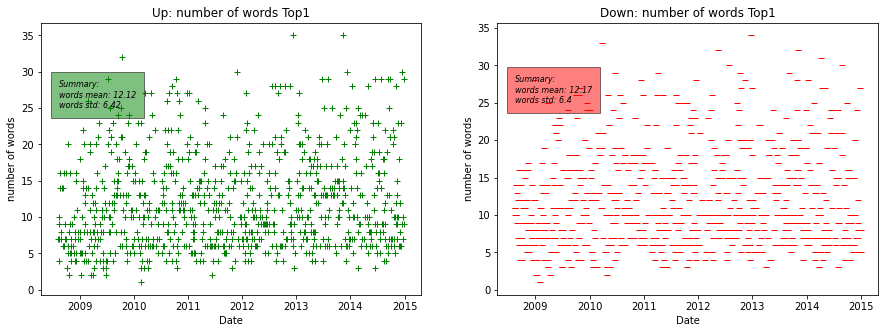

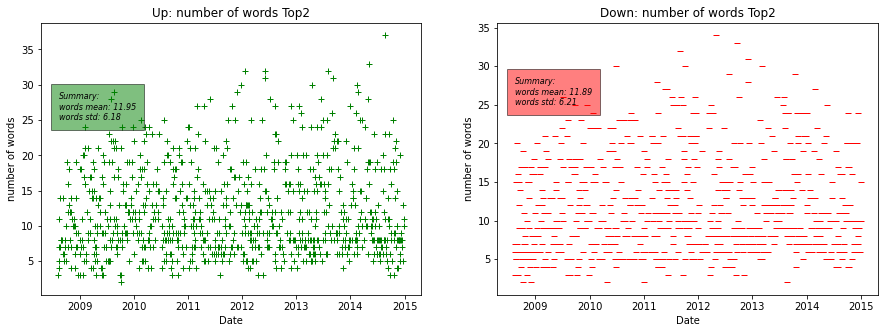

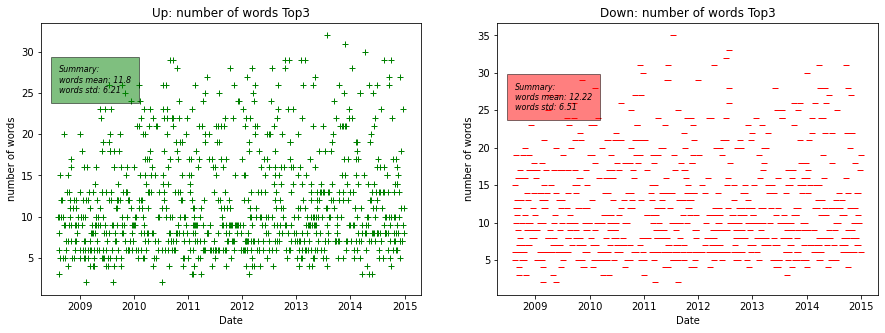

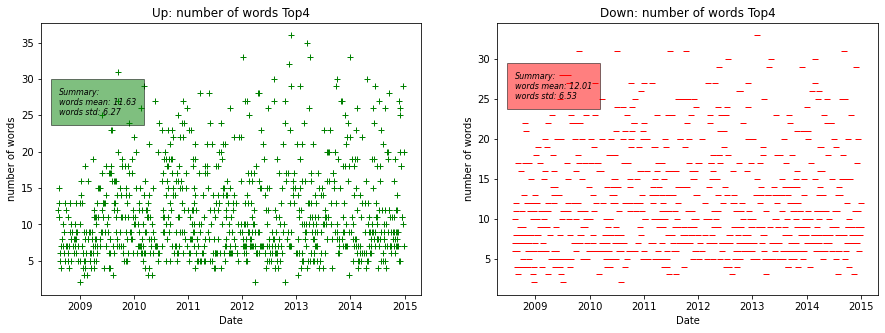

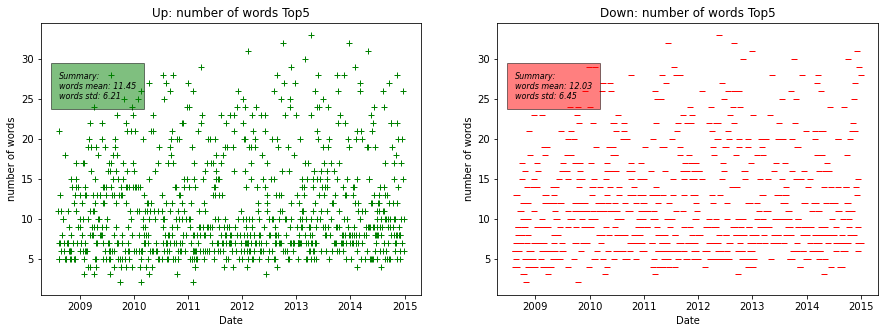

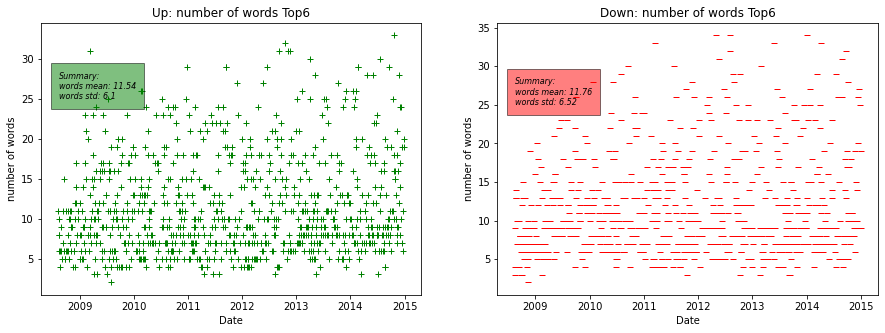

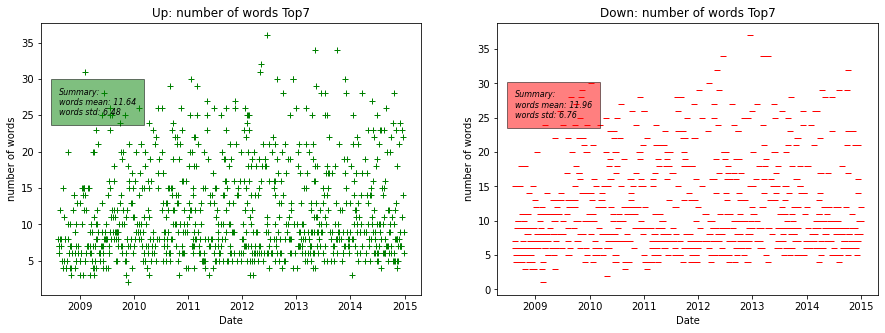

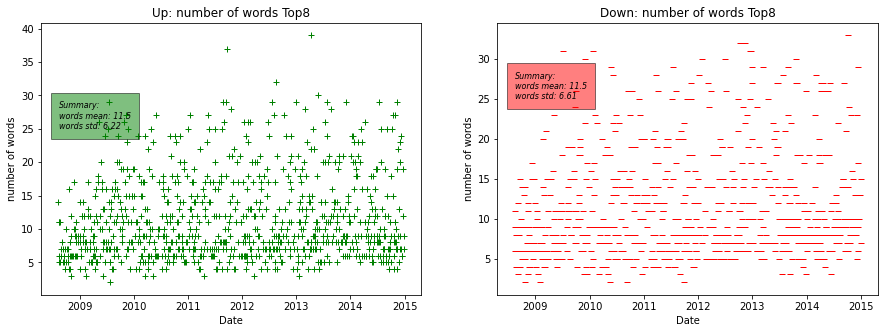

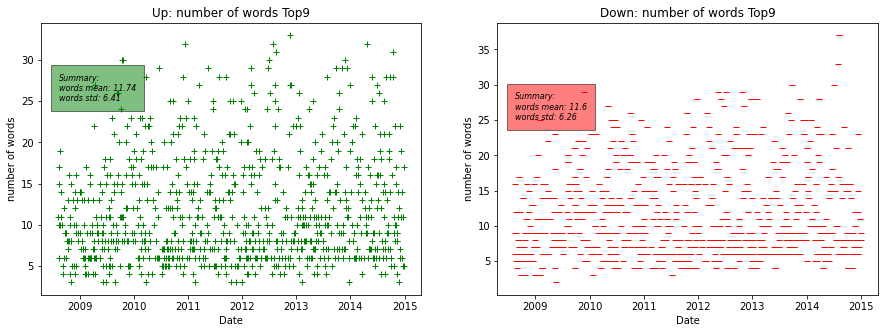

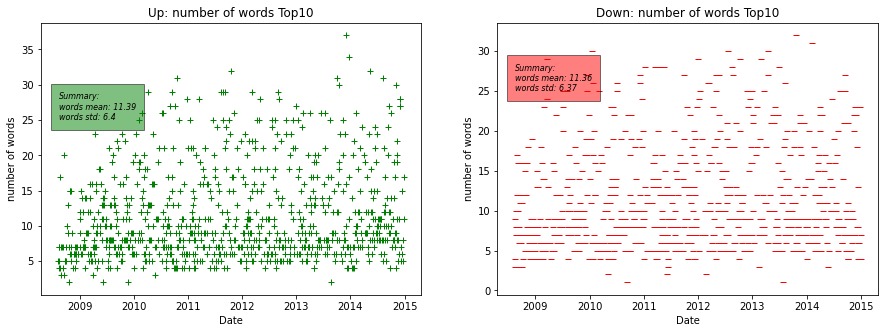

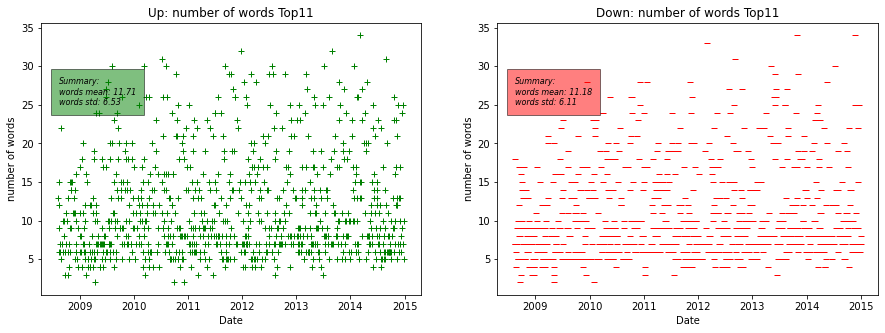

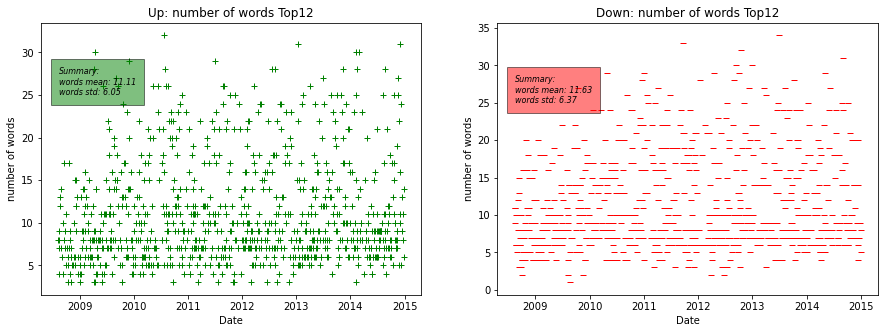

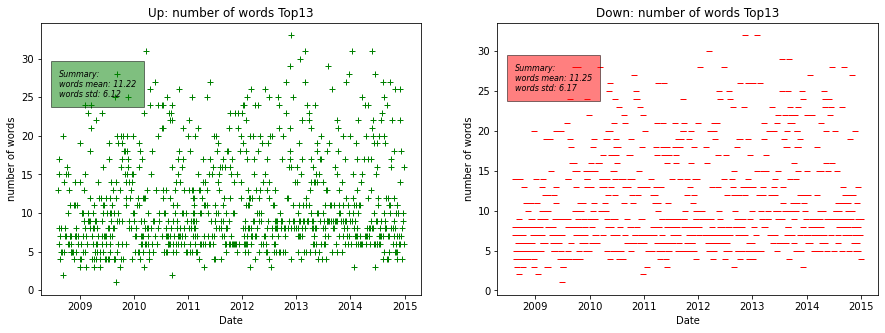

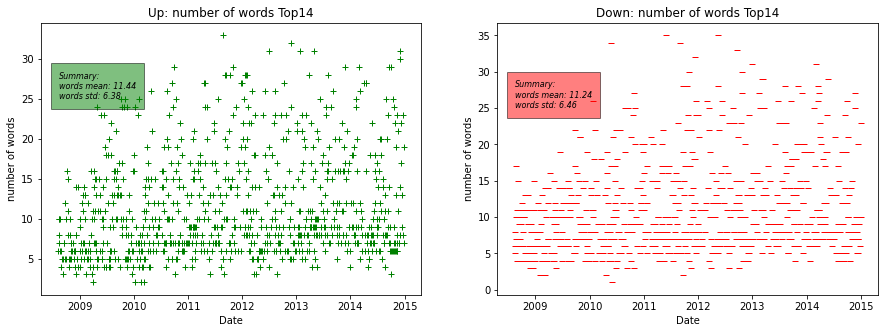

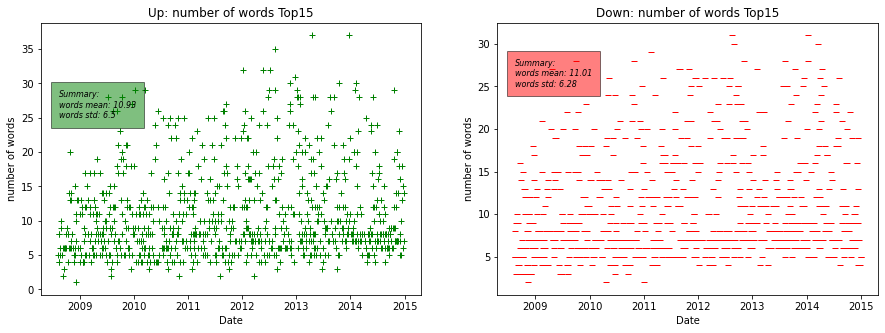

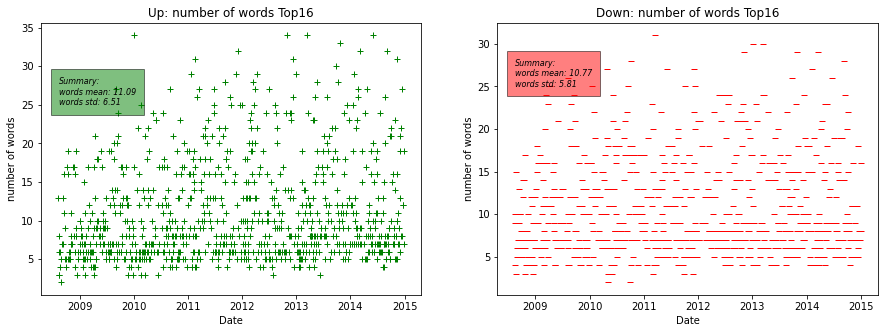

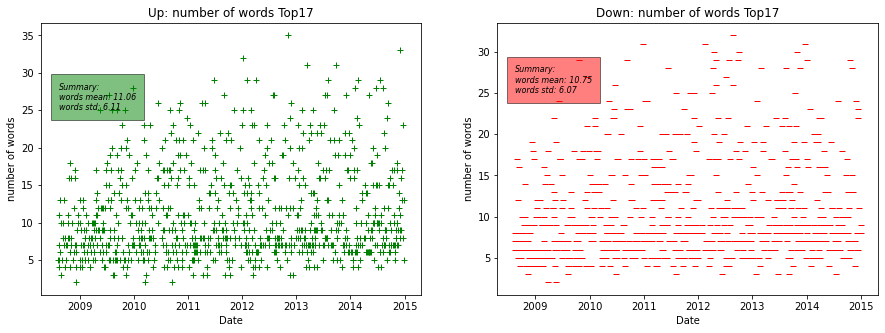

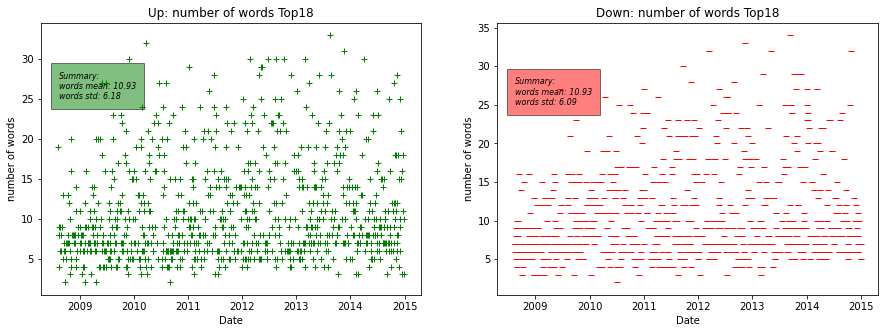

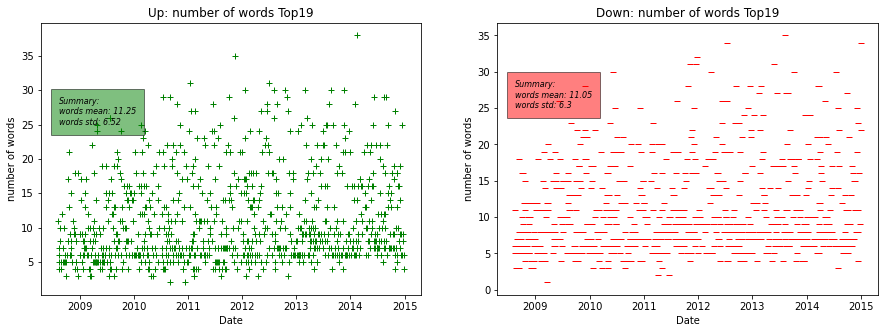

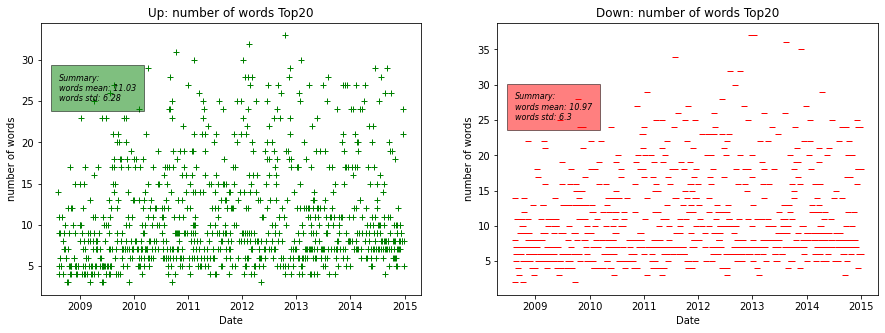

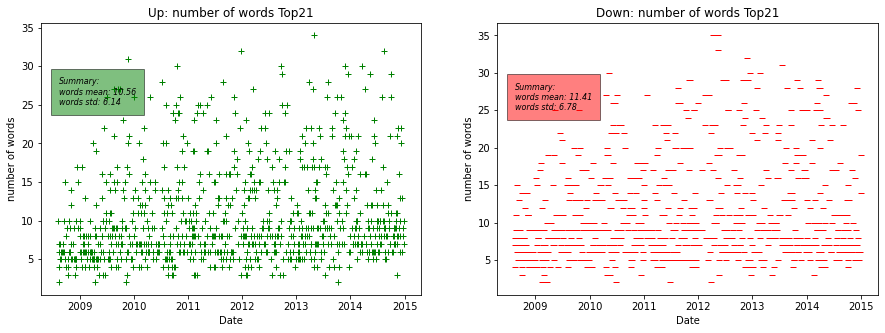

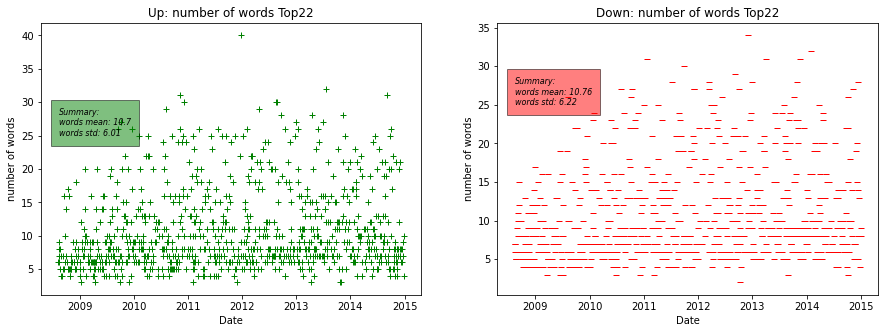

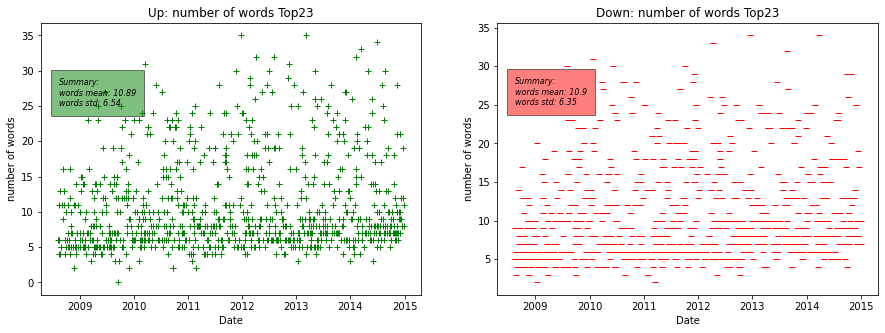

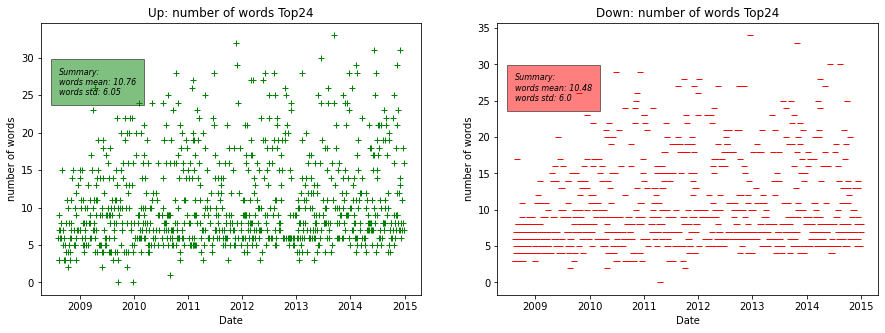

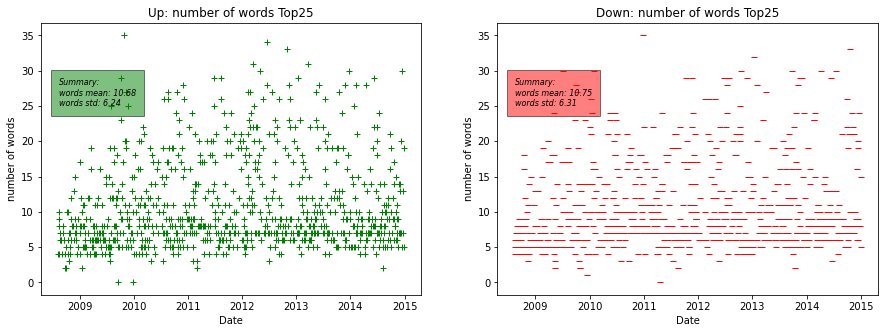

In [111]:
for i in range(25):
    f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
    
    axes[0].set_ylabel("number of words")
    axes[0].set_xlabel("Date")
    axes[0].set_title(f"Up: number of words Top{i+1}")    
    txt = f"Summary:\nwords mean: {round(wl_up[i].mean(),2)}\nwords std: {round(wl_up[i].std(),2)}"
    axes[0].text(pd.Timestamp('2008-08-14 00:00:00'), 25,txt,size=8,style = 'italic',bbox=dict(facecolor='g',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
    axes[0].plot(up.index, wl_up[i], 'g+')
    
    axes[1].set_ylabel("number of words")
    axes[1].set_xlabel("Date")
    axes[1].set_title(f"Down: number of words Top{i+1}")
    txt = f"Summary:\nwords mean: {round(wl_down[i].mean(),2)}\nwords std: {round(wl_down[i].std(),2)}"
    axes[1].text(pd.Timestamp('2008-08-14 00:00:00'), 25,txt,size=8,style = 'italic',bbox=dict(facecolor='r',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
    axes[1].plot(down.index, wl_down[i], 'r_')

### Word Clouds

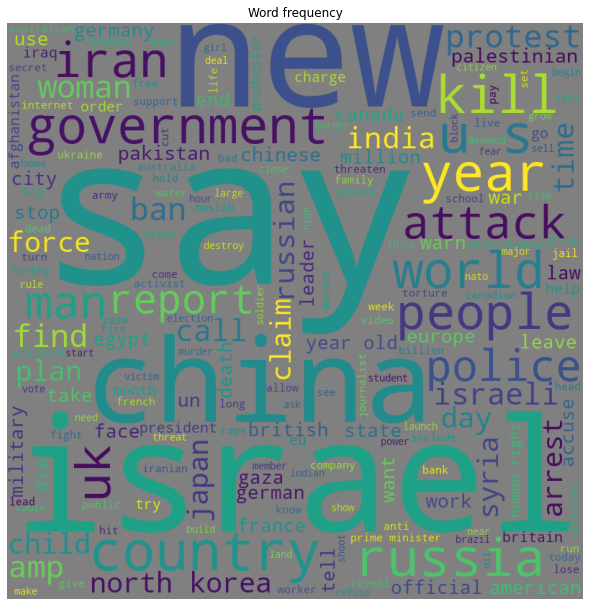

In [112]:
trainheadlines = []
testheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,0:25]))
for row in range(0,len(test.index)):    
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,0:25]))

comment_words = ''
# iterate through the list
for Doc in trainheadlines:      
    # split the value
    tokens = Doc.split()
    comment_words += " ".join(tokens)
        
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='gray',
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word frequency")  
plt.show()

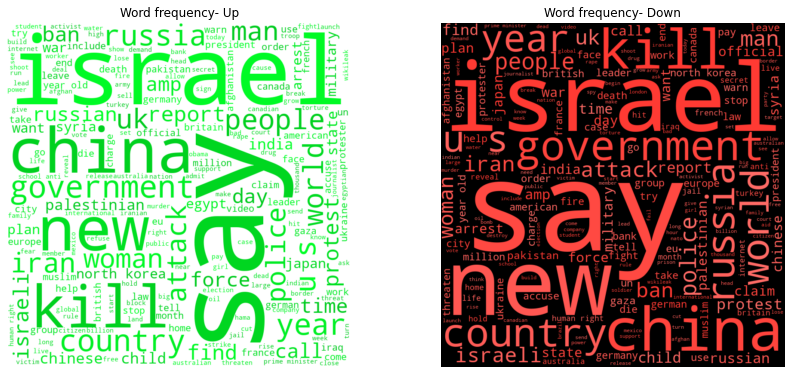

In [113]:
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(2, 100%%, %50d%%)" % random.randint(60, 70)  

def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(129, 100%%, %50d%%)" % random.randint(40, 50)  

from PIL import Image
up_mask = np.array(Image.open('up arrow.png'))

# up
upheadlines = []
for row in range(len(up.index)):
    upheadlines.append(' '.join(str(x) for x in up.iloc[row,0:25]))
Up_corpus = upheadlines
Up_words = " ".join(Up_corpus)
Up_vocabulary = list(set(Up_words.split(" ")))
up_comment_words = ''
# iterate through the list
for Doc in Up_corpus:      
    # split the value
    tokens = Doc.split()
    up_comment_words += " ".join(tokens)
        
up_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(up_comment_words)

                
#down
downheadlines = []
for row in range(len(down.index)):
    downheadlines.append(' '.join(str(x) for x in down.iloc[row,0:25]))
Down_corpus = downheadlines
Down_words = " ".join(Down_corpus)
Down_vocabulary = list(set(Down_words.split(" ")))
down_comment_words = ''
# iterate through the list
for Doc in Down_corpus:      
    # split the value
    down_tokens = Doc.split()
    down_comment_words += " ".join(down_tokens)
        
down_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(down_comment_words)

f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
                  

#up plot
axes[0].imshow(up_wordcloud.recolor(color_func=green_color_func, random_state=3)
,interpolation="bilinear")
axes[0].axis("off")
f.tight_layout(pad = 0)
axes[0].set_title("Word frequency- Up")


#down plot
axes[1].imshow(down_wordcloud.recolor(color_func=red_color_func, random_state=3),
interpolation="bilinear")
axes[1].axis("off")
f.tight_layout(pad = 0)
axes[1].set_title("Word frequency- Down");  

## Topic modeling

topic modeling with 2 approaches:
1. Non Negative Matrix Factorization (NMF).
2. Latent Dirichlet Allocation (LDA).

for each approach:
* 10 topics.
* 10 most significant words for each topic.

In [114]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, max_features=no_features, ngram_range=(1, 3))
tfidf = tfidf_vectorizer.fit_transform(trainheadlines)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


# LDA can only use raw term counts because it is a probabilistic graphical model
rc_vectorizer = CountVectorizer(max_df=0.9, min_df=5, max_features=no_features, ngram_range=(1, 3))#rc - raw count
rc = rc_vectorizer.fit_transform(trainheadlines)
rc_feature_names = rc_vectorizer.get_feature_names()

In [115]:
#identifying 10 topics in the headlines
no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(rc)

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
                        

no_top_words = 10 #number of words for each topic
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
year say world new police china kill government people country
Topic 1:
gaza israel israeli hamas palestinians war palestinian un idf soldier
Topic 2:
ukraine russia russian ukrainian putin georgia say nato military pro
Topic 3:
korea north north korea korean south south korea north korean missile kim jong
Topic 4:
libya gaddafi libyan fukushima japan nuclear reactor rebel plant tsunami
Topic 5:
wikileaks assange julian julian assange cable founder sweden leak ecuador release
Topic 6:
snowden nsa edward edward snowden surveillance spy asylum leak reveal hong kong
Topic 7:
isis ebola islamic state islamic state iraq militant hamas kong hong kong
Topic 8:
egypt mubarak egyptian protest protester jazeera al jazeera square al pro
Topic 9:
bin laden bin laden pakistani pakistan raid death reactor drug killing


In [116]:
display_topics(lda, rc_feature_names, no_top_words)

Topic 0:
snowden nsa edward edward snowden surveillance asylum hong kong kong hong spy
Topic 1:
nsa venezuela ambassador russian georgia bomber bush snowden order leave
Topic 2:
say year world new china kill russia government country north
Topic 3:
gaza nsa israeli israel snowden edward edward snowden un kill say
Topic 4:
assange wikileaks julian julian assange cable founder ecuador embassy sweden say
Topic 5:
mubarak pro square cable government year nobel democracy election attack
Topic 6:
georgia russia war pakistan russian military south missile conflict kill
Topic 7:
police year government say people kill israeli israel new uk
Topic 8:
israel gaza israeli hamas war kill palestinians un fire russia
Topic 9:
bin laden bin laden pakistan al kill dead al qaeda fukushima death


# predictions
## models

5 classification models are used for a basic prediction:

In [117]:
random.seed(1)
models = {"Decision Tree":DecisionTreeClassifier(), 
          "Random Forest":RandomForestClassifier(), 
          "Logistic Regression":LogisticRegression(),
          "Gaussian Naive Bayse":GaussianNB(), 
          "Support Vector Machines":SVC()}

train["Stock_change"] = train["Stock_change"].apply(lambda x: 1 if x=="up" else 0)
test["Stock_change"] = test["Stock_change"].apply(lambda x: 1 if x=="up" else 0)

### Raw count corpus prediction

In [118]:
vocab_df = pd.DataFrame(rc.toarray(),train.index, columns = rc_feature_names)
vocab_df.sample()

000  000 people  10  100  11  12  13  14  15  16  ...  wrong  \
Date                                                          ...          
2014-04-01    2           0   0    0   0   0   0   0   0   0  ...      0   

            year  year ago  year old  yemen  young  youth  zealand  zimbabwe  \
Date                                                                           
2014-04-01     0         0         0      1      0      0        0         0   

            zone  
Date              
2014-04-01     0  

[1 rows x 1000 columns]

In [119]:

vocab_test =  pd.DataFrame(rc_vectorizer.transform(testheadlines).toarray(),index = test.index, columns = rc_vectorizer.get_feature_names())
vocab_test = vocab_test[vocab_df.columns.tolist()]#use only 

for m,v in models.items():
    v.fit(vocab_df, train["Stock_change"])
    predictions = v.predict(vocab_test)
    print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
    print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
    print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")

Decision Tree :
 Predicted   0    1
Actual            
0          81   97
1          99  101 

accuracy score:  0.48148148148148145
roc auc score:  0.48002808988764045 

Random Forest :
 Predicted   0    1
Actual            
0          39  139
1          46  154 

accuracy score:  0.5105820105820106
roc auc score:  0.4945505617977528 

Logistic Regression :
 Predicted    0   1
Actual            
0          100  78
1          116  84 

accuracy score:  0.48677248677248675
roc auc score:  0.4908988764044944 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          83   95
1          97  103 

accuracy score:  0.49206349206349204
roc auc score:  0.49064606741573036 

Support Vector Machines :
 Predicted   0    1
Actual            
0          32  146
1          27  173 

accuracy score:  0.5423280423280423
roc auc score:  0.5223876404494382 



## tf-idf corpus prediction

In [120]:
vocab_df2 = pd.DataFrame(tfidf.toarray(),train.index, columns = tfidf_feature_names)
vocab_df2.sample()

000  000 people        10  100   11       12   13   14   15   16  \
Date                                                                           
2010-12-10  0.0         0.0  0.056311  0.0  0.0  0.07132  0.0  0.0  0.0  0.0   

            ...  wrong  year  year ago  year old  yemen  young  youth  \
Date        ...                                                         
2010-12-10  ...    0.0   0.0       0.0       0.0    0.0    0.0    0.0   

            zealand  zimbabwe  zone  
Date                                 
2010-12-10      0.0       0.0   0.0  

[1 rows x 1000 columns]

In [121]:
vocab_test =  pd.DataFrame(tfidf_vectorizer.transform(testheadlines).toarray(),index = test.index, columns = tfidf_vectorizer.get_feature_names())
vocab_test = vocab_test[vocab_df2.columns.tolist()]#use only 
for m,v in models.items():
    v.fit(vocab_df2, train["Stock_change"])
    predictions = v.predict(vocab_test)
    print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
    print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
    print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")

Decision Tree :
 Predicted    0   1
Actual            
0           82  96
1          111  89 

accuracy score:  0.4523809523809524
roc auc score:  0.45283707865168543 

Random Forest :
 Predicted   0    1
Actual            
0          39  139
1          52  148 

accuracy score:  0.4947089947089947
roc auc score:  0.4795505617977528 

Logistic Regression :
 Predicted   0    1
Actual            
0          64  114
1          66  134 

accuracy score:  0.5238095238095238
roc auc score:  0.5147752808988764 

Gaussian Naive Bayse :
 Predicted    0   1
Actual            
0           91  87
1          102  98 

accuracy score:  0.5
roc auc score:  0.5006179775280899 

Support Vector Machines :
 Predicted   0    1
Actual            
0          33  145
1          28  172 

accuracy score:  0.5423280423280423
roc auc score:  0.5226966292134831 



## topic modeling (Lda)

**note** A funciton for transforming the headline into it's classified topic is created.
### train lables

In [122]:
def topic_tranformer(text,vectorizer = rc_vectorizer,transformer = lda):
    """
    this function takes a column and vectorizes the words of each rows (raw count as default), 
    transforms with dimension reduction teqnique (lda count as default)
    and takes the indices max of each row as the topic number.
    """
    vec = vectorizer.transform(text)#transform a test column.
    transform = transformer.transform(vec)#use LDA for the topic modeling.
    topic = transform.argmax(axis = 1)#get the topic who scored the highest.
    return(topic)

In [123]:
topic_df = train.copy()
for i in range(25):#for each column
    topic_df[f"Top{i+1}"] = topic_tranformer(topic_df.iloc[:,i])#identify the topic
topic_df.head(2)

Top1  Top2  Top3  Top4  Top5  Top6  Top7  Top8  Top9  Top10  ...  \
Date                                                                     ...   
2008-08-08     6     0     6     8     6     2     6     7     7      6  ...   
2008-08-11     6     6     8     8     6     2     6     6     6      6  ...   

            Top17  Top18  Top19  Top20  Top21  Top22  Top23  Top24  Top25  \
Date                                                                        
2008-08-08      9      8      2      6      2      6      7      2      6   
2008-08-11      6      7      6      6      8      6      6      6      2   

            Stock_change  
Date                      
2008-08-08             1  
2008-08-11             1  

[2 rows x 26 columns]

In [124]:
topic_test = test.copy()
for i in range(25):
    topic_test[f"Top{i+1}"] = topic_tranformer(topic_test.iloc[:,i])#transform the test data 
topic_test.head(2)

Top1  Top2  Top3  Top4  Top5  Top6  Top7  Top8  Top9  Top10  ...  \
Date                                                                     ...   
2015-01-02     2     2     2     7     2     2     7     7     2      2  ...   
2015-01-05     2     2     2     2     2     2     2     7     2      6  ...   

            Top17  Top18  Top19  Top20  Top21  Top22  Top23  Top24  Top25  \
Date                                                                        
2015-01-02      2      8      2      7      2      2      2      2      2   
2015-01-05      7      2      2      7      2      2      2      2      2   

            Stock_change  
Date                      
2015-01-02             0  
2015-01-05             0  

[2 rows x 26 columns]

Predicting using 25 headlines than going down to 1, for each model.
meaning 125 predictions:

In [125]:
for i in range(25,0,-1):
    print(f"top {i} headlines\n","#"*100)
    for m,v in models.items():
        v.fit(topic_df.iloc[:,:25], train["Stock_change"])
        predictions = v.predict(topic_test.iloc[:,:25])
        print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
        print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
        print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")

top 25 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          76  102
1          80  120 

accuracy score:  0.5185185185185185
roc auc score:  0.5134831460674157 

Random Forest :
 Predicted   0    1
Actual            
0          61  117
1          53  147 

accuracy score:  0.5502645502645502
roc auc score:  0.5388483146067415 

Logistic Regression :
 Predicted   0    1
Actual            
0          49  129
1          41  159 

accuracy score:  0.5502645502645502
roc auc score:  0.5351404494382023 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          45  133
1          41  159 

accuracy score:  0.5396825396825397
roc auc score:  0.5239044943820225 

Support Vector Machines :
 Predicted   0    1
Actual            
0          43  135
1          37  163 

accuracy score:  0.544973544973545
roc auc score:  0.5282865168539326 

top 24 headlines
 #

Support Vector Machines :
 Predicted   0    1
Actual            
0          43  135
1          37  163 

accuracy score:  0.544973544973545
roc auc score:  0.5282865168539326 

top 16 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          69  109
1          83  117 

accuracy score:  0.49206349206349204
roc auc score:  0.4863202247191011 

Random Forest :
 Predicted   0    1
Actual            
0          55  123
1          53  147 

accuracy score:  0.5343915343915344
roc auc score:  0.521994382022472 

Logistic Regression :
 Predicted   0    1
Actual            
0          49  129
1          41  159 

accuracy score:  0.5502645502645502
roc auc score:  0.5351404494382023 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          45  133
1          41  159 

accuracy score:  0.5396825396825397
roc auc score:  0.5239044943820225 

Support Vector Mach

Random Forest :
 Predicted   0    1
Actual            
0          67  111
1          62  138 

accuracy score:  0.5423280423280423
roc auc score:  0.5332022471910112 

Logistic Regression :
 Predicted   0    1
Actual            
0          49  129
1          41  159 

accuracy score:  0.5502645502645502
roc auc score:  0.5351404494382023 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          45  133
1          41  159 

accuracy score:  0.5396825396825397
roc auc score:  0.5239044943820225 

Support Vector Machines :
 Predicted   0    1
Actual            
0          43  135
1          37  163 

accuracy score:  0.544973544973545
roc auc score:  0.5282865168539326 

top 7 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          75  103
1          89  111 

accuracy score:  0.49206349206349204
roc auc score:  0.4881741573033708 

Random Forest :
 Pr

## topic modeling (NMF)
### train lables

In [126]:
topic_df2 = train.copy()
for i in range(25):
    topic_df2[f"Top{i+1}"] = topic_tranformer(topic_df2.iloc[:,i],vectorizer = tfidf_vectorizer,transformer = nmf)#this time, tf-idf and nmf is applied. 
topic_df2.head(2)

Top1  Top2  Top3  Top4  Top5  Top6  Top7  Top8  Top9  Top10  ...  \
Date                                                                     ...   
2008-08-08     2     0     2     2     0     2     2     0     0      2  ...   
2008-08-11     0     1     1     2     0     0     2     0     0      2  ...   

            Top17  Top18  Top19  Top20  Top21  Top22  Top23  Top24  Top25  \
Date                                                                        
2008-08-08      0      1      0      2      0      2      0      0      0   
2008-08-11      2      0      0      3      1      2      2      2      0   

            Stock_change  
Date                      
2008-08-08             1  
2008-08-11             1  

[2 rows x 26 columns]

In [127]:
topic_test2 = test.copy()
for i in range(25):
    topic_test2[f"Top{i+1}"] = topic_tranformer(topic_test2.iloc[:,i],vectorizer = tfidf_vectorizer,transformer = nmf)#this time, tf-idf and nmf is applied. 
topic_test2.head(2)

Top1  Top2  Top3  Top4  Top5  Top6  Top7  Top8  Top9  Top10  ...  \
Date                                                                     ...   
2015-01-02     0     7     0     0     0     0     0     0     0      0  ...   
2015-01-05     0     8     3     0     0     0     1     0     8      0  ...   

            Top17  Top18  Top19  Top20  Top21  Top22  Top23  Top24  Top25  \
Date                                                                        
2015-01-02      1      1      0      4      0      6      2      0      2   
2015-01-05      0      2      0      4      0      2      0      2      0   

            Stock_change  
Date                      
2015-01-02             0  
2015-01-05             0  

[2 rows x 26 columns]

In [128]:
for i in range(25,0,-1):
    print(f"top {i} headlines\n","#"*100)
    for m,v in models.items():    
        v.fit(topic_df2.iloc[:,:i], train["Stock_change"])
        predictions = v.predict(topic_test2.iloc[:,:i])
        print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
        print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
        print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")    

top 25 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          88   90
1          86  114 

accuracy score:  0.5343915343915344
roc auc score:  0.532191011235955 

Random Forest :
 Predicted   0    1
Actual            
0          64  114
1          62  138 

accuracy score:  0.5343915343915344
roc auc score:  0.5247752808988764 

Logistic Regression :
 Predicted   0    1
Actual            
0          55  123
1          47  153 

accuracy score:  0.5502645502645502
roc auc score:  0.5369943820224719 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          75  103
1          84  116 

accuracy score:  0.5052910052910053
roc auc score:  0.5006741573033708 

Support Vector Machines :
 Predicted   0    1
Actual            
0          53  125
1          48  152 

accuracy score:  0.5423280423280423
roc auc score:  0.528876404494382 

top 24 headlines
 ##

Support Vector Machines :
 Predicted   0    1
Actual            
0          39  139
1          40  160 

accuracy score:  0.5264550264550265
roc auc score:  0.5095505617977528 

top 16 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          79   99
1          76  124 

accuracy score:  0.5370370370370371
roc auc score:  0.5319101123595505 

Random Forest :
 Predicted   0    1
Actual            
0          62  116
1          59  141 

accuracy score:  0.5370370370370371
roc auc score:  0.5266573033707864 

Logistic Regression :
 Predicted   0    1
Actual            
0          30  148
1          40  160 

accuracy score:  0.5026455026455027
roc auc score:  0.4842696629213483 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          70  108
1          70  130 

accuracy score:  0.5291005291005291
roc auc score:  0.5216292134831461 

Support Vector Mac

Random Forest :
 Predicted   0    1
Actual            
0          72  106
1          66  134 

accuracy score:  0.544973544973545
roc auc score:  0.537247191011236 

Logistic Regression :
 Predicted   0    1
Actual            
0          14  164
1          16  184 

accuracy score:  0.5238095238095238
roc auc score:  0.49932584269662916 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          69  109
1          66  134 

accuracy score:  0.5370370370370371
roc auc score:  0.5288202247191011 

Support Vector Machines :
 Predicted   0    1
Actual            
0          43  135
1          59  141 

accuracy score:  0.48677248677248675
roc auc score:  0.4732865168539326 

top 7 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          73  105
1          80  120 

accuracy score:  0.5105820105820106
roc auc score:  0.5050561797752808 

Random Forest :
 Pr

## Time Series Cross Validation

for cross validation we need to use time series dependant cv for accurate prediction with no data leakage.
the splits are printed for clarification.

In [129]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [130]:
X = pd.concat([topic_df2.iloc[:,:10],topic_test2.iloc[:,:10]])
y = pd.concat([train.iloc[:,25:26],test.iloc[:,25:26]])
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "\nTEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [131]:

for train_index, test_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index[0]:train_index[-1],:], X.iloc[test_index[0]:test_index[-1],:]
    y_train, y_val = y.iloc[train_index[0]:train_index[-1],:], y.iloc[test_index[0]:test_index[-1],:]
    clf = RandomForestClassifier(random_state = 37)
    grid_values = {'criterion' : ["gini","entropy"],
 'max_depth': [None,4,6],
 'min_samples_leaf': [2,3, None],
 'min_samples_split': [2,3,None],
 'n_estimators': [100, None]}
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'balanced_accuracy',n_jobs = -1)
    grid_clf_acc.fit(X_train, y_train)
    y_pred_acc = grid_clf_acc.predict(X_val)                            
    print('Accuracy Score : ' + str(accuracy_score(y_val,y_pred_acc)))
    print('Roc Score : ' + str(roc_auc_score(y_val,y_pred_acc)))
    print(classification_report(y_val,y_pred_acc))

Accuracy Score : 0.48787878787878786
Roc Score : 0.46868592730661696
              precision    recall  f1-score   support

           0       0.39      0.31      0.35       145
           1       0.54      0.63      0.58       185

    accuracy                           0.49       330
   macro avg       0.47      0.47      0.46       330
weighted avg       0.47      0.49      0.48       330

Accuracy Score : 0.49393939393939396
Roc Score : 0.4698772915434654
              precision    recall  f1-score   support

           0       0.38      0.16      0.23       152
           1       0.52      0.78      0.62       178

    accuracy                           0.49       330
   macro avg       0.45      0.47      0.43       330
weighted avg       0.46      0.49      0.44       330

Accuracy Score : 0.49696969696969695
Roc Score : 0.48151581445363195
              precision    recall  f1-score   support

           0       0.42      0.32      0.37       149
           1       0.53      0.

# Method 2 - Using TF-IDF and model pipelines

This method is used to try to minimize code length and search for the best model in a single pipeline for all the preprocessing and classification and extract insights.
first the dataset will be combined again.

In [132]:
#NDX
NDX = pd.read_csv("NDX.csv")
NDX["Stock_change"] =  np.where(NDX['Open']<= NDX['Adj Close'], "up", "down")
#reddit
r_news = pd.read_csv("r_news.csv")
r_news.drop("Unnamed: 0",axis = 1, inplace = True)
#convert date to datetime
r_news["Date"] = pd.to_datetime(r_news["Date"])
r_news["Date"].head()
#add the ndx trend (up/down)
r_news["Stock_change"] = NDX.iloc[:,-1].values
# remove the Date columns
r_news.set_index("Date",inplace = True)
r_news.head(2)

Top1  \
Date                                                            
2008-08-08  b"Georgia 'downs two Russian warplanes' as cou...   
2008-08-11  b'Why wont America and Nato help us? If they w...   

                                                   Top2  \
Date                                                      
2008-08-08      b'BREAKING: Musharraf to be impeached.'   
2008-08-11  b'Bush puts foot down on Georgian conflict'   

                                                         Top3  \
Date                                                            
2008-08-08  b'Russia Today: Columns of troops roll into So...   
2008-08-11  b"Jewish Georgian minister: Thanks to Israeli ...   

                                                         Top4  \
Date                                                            
2008-08-08  b'Russian tanks are moving towards the capital...   
2008-08-11  b'Georgian army flees in disarray as Russians ...   

                                                         Top5  \
Date                                                            
2008-08-08  b"Afghan children raped with 'impunity,' U.N. ...   
2008-08-11      b"Olympic opening ceremony fireworks 'faked'"   

                                                         Top6  \
Date                                                            
2008-08-08  b'150 Russian tanks have entered South Ossetia...   
2008-08-11  b'What were the Mossad with fraudulent New Zea...   

                                                         Top7  \
Date                                                            
2008-08-08  b"Breaking: Georgia invades South Ossetia, Rus...   
2008-08-11  b'Russia angered by Israeli military sale to G...   

                                                         Top8  \
Date                                                            
2008-08-08  b"The 'enemy combatent' trials are nothing but...   
2008-08-11  b'An American citizen living in S.Ossetia blam...   

                                                         Top9  \
Date                                                            
2008-08-08  b'Georgian troops retreat from S. Osettain cap...   
2008-08-11  b'Welcome To World War IV! Now In High Definit...   

                                                        Top10  ...  \
Date                                                           ...   
2008-08-08  b'Did the U.S. Prep Georgia for War with Russia?'  ...   
2008-08-11  b"Georgia's move, a mistake of monumental prop...  ...   

                                                        Top17  \
Date                                                            
2008-08-08                b'Al-Qaeda Faces Islamist Backlash'   
2008-08-11  b'"Do not believe TV, neither Russian nor Geor...   

                                                        Top18  \
Date                                                            
2008-08-08  b'Condoleezza Rice: "The US would not act to p...   
2008-08-11  b'Riots are still going on in Montreal (Canada...   

                                                        Top19  \
Date                                                            
2008-08-08  b'This is a busy day:  The European Union has ...   
2008-08-11    b'China to overtake US as largest manufacturer'   

                                                        Top20  \
Date                                                            
2008-08-08  b"Georgia will withdraw 1,000 soldiers from Ir...   
2008-08-11                     b'War in South Ossetia [PICS]'   

                                                        Top21  \
Date                                                            
2008-08-08  b'Why the Pentagon Thinks Attacking Iran is a ...   
2008-08-11  b'Israeli Physicians Group Condemns State Tort...   

                                                        Top22  \
Date                                                            
2008-08-08  b'Ca

## Text cleaning
This time the approach the `replace` method will be used to clear the initial "b" in all headlines:

In [133]:
r_news = r_news.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
r_news.head(3)

Top1  \
Date                                                            
2008-08-08  Georgia 'downs two Russian warplanes' as count...   
2008-08-11  Why wont America and Nato help us? If they won...   
2008-08-12  Remember that adorable 9-year-old who sang at ...   

                                                 Top2  \
Date                                                    
2008-08-08      BREAKING: Musharraf to be impeached.'   
2008-08-11  Bush puts foot down on Georgian conflict'   
2008-08-12            Russia 'ends Georgia operation'   

                                                         Top3  \
Date                                                            
2008-08-08  Russia Today: Columns of troops roll into Sout...   
2008-08-11  Jewish Georgian minister: Thanks to Israeli tr...   
2008-08-12  If we had no sexual harassment we would have n...   

                                                         Top4  \
Date                                                            
2008-08-08  Russian tanks are moving towards the capital o...   
2008-08-11  Georgian army flees in disarray as Russians ad...   
2008-08-12  Al-Qa'eda is losing support in Iraq because of...   

                                                         Top5  \
Date                                                            
2008-08-08  Afghan children raped with 'impunity,' U.N. of...   
2008-08-11         Olympic opening ceremony fireworks 'faked'   
2008-08-12  Ceasefire in Georgia: Putin Outmaneuvers the W...   

                                                         Top6  \
Date                                                            
2008-08-08  150 Russian tanks have entered South Ossetia w...   
2008-08-11  What were the Mossad with fraudulent New Zeala...   
2008-08-12  Why Microsoft and Intel tried to kill the XO $...   

                                                         Top7  \
Date                                                            
2008-08-08  Breaking: Georgia invades South Ossetia, Russi...   
2008-08-11  Russia angered by Israeli military sale to Geo...   
2008-08-12  Stratfor: The Russo-Georgian War and the Balan...   

                                                         Top8  \
Date                                                            
2008-08-08  The 'enemy combatent' trials are nothing but a...   
2008-08-11  An American citizen living in S.Ossetia blames...   
2008-08-12  I'm Trying to Get a Sense of This Whole Georgi...   

                                                         Top9  \
Date                                                            
2008-08-08  Georgian troops retreat from S. Osettain capit...   
2008-08-11  Welcome To World War IV! Now In High Definition!'   
2008-08-12  The US military was surprised by the timing an...   

                                                        Top10  ...  \
Date                                                           ...   
2008-08-08    Did the U.S. Prep Georgia for War with Russia?'  ...   
2008-08-11  Georgia's move, a mistake of monumental propor...  ...   
2008-08-12      U.S. Beats War Drum as Iran Dumps the Dollar'  ...   

                                                        Top17  \
Date                                                            
2008-08-08                  Al-Qaeda Faces Islamist Backlash'   
2008-08-11  Do not believe TV, neither Russian nor Georgia...   
2008-08-12         Why Russias response to Georgia was right'   

                                                        Top18  \
Date                                                            
2008-08-08  Condoleezza Rice: The US would not act to prev...   
2008-08-11  Riots are still going on in Montreal (Canada) ...   
2008-08-12  Gorbachev accuses U.S. of making a serious blu...   

                                                        Top19  \
Date                                                            
2008-08-08  This is a busy day

Now all the headlines of each day will be combined to a single column:

In [134]:
r_news["Stock_change"] = r_news["Stock_change"].apply(lambda s: 0 if s=="down" else 1)# convert target to numbers 
r_news = r_news[[r_news.columns.tolist()[25]]+r_news.columns.tolist()[0:25]] # change column order target is first
news = r_news.columns.tolist()[1:26] # list of headline columns
r_news[news] = r_news[news].astype('str') #convert to string to join
r_news["comb_news"] = r_news[news].apply(lambda x: ' '.join(x), axis = 1) #join all of the headlines of each row

r_news.drop(news,axis = 1, inplace = True) #drop seperated headlines
r_news["comb_news"][0] #print a single row to check result.

"Georgia 'downs two Russian warplanes' as countries move to brink of war BREAKING: Musharraf to be impeached.' Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)' Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire' Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing 150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.' Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO's side The 'enemy combatent' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it. Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]' Did the U.S. Prep Georgia for War with Russia?' Rice Gives Green Light for Israel to Attac

Now that all the news are combined New features will be extracted from them:

In [135]:
r_news.sample()

Stock_change                                          comb_news
Date                                                                       
2015-02-25             0  ISIS Burns 8000 Rare Books and Manuscripts in ...

In [136]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

SW = set(STOPWORDS)
SW.update(["u","will","us","","says"])

def processing(r_news):
    #lowering and removing punctuation
    r_news['processed'] = r_news['comb_news'].apply(lambda x: clean_text(x))
    
    #numerical feature engineering
    #total length of sentence
    r_news['length'] = r_news['processed'].apply(lambda x: len(x))
    #get number of words
    r_news['words'] = r_news['processed'].apply(lambda x: len(x.split(' ')))
    r_news['words_not_stopword'] = r_news['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in SW]))
    #get the average word length
    r_news['avg_word_length'] = r_news['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in SW]) if len([len(t) for t in x.split(' ') if t not in SW]) > 0 else 0)
    return(r_news)

r_news = processing(r_news)

r_news.head()

Stock_change                                          comb_news  \
Date                                                                          
2008-08-08             1  Georgia 'downs two Russian warplanes' as count...   
2008-08-11             1  Why wont America and Nato help us? If they won...   
2008-08-12             1  Remember that adorable 9-year-old who sang at ...   
2008-08-13             1   U.S. refuses Israel weapons to attack Iran: r...   
2008-08-14             1  All the experts admit that we should legalise ...   

                                                    processed  length  words  \
Date                                                                           
2008-08-08  georgia downs two russian warplanes as countri...    2205    377   
2008-08-11  why wont america and nato help us if they wont...    1542    273   
2008-08-12  remember that adorable  who sang at the openin...    1989    354   
2008-08-13   us refuses israel weapons to attack iran repo...    1876    311   
2008-08-14  all the experts admit that we should legalise ...    1709    279   

            words_not_stopword  avg_word_length  
Date                                             
2008-08-08                 233         6.193133  
2008-08-11                 164         6.073171  
2008-08-12                 196         6.377551  
2008-08-13                 200         6.500000  
2008-08-14                 185         6.545946

The new features:
* **processed** The combined news after cleaning the text from punctioations.
* **length** The total length of the sentence string.
* **words** The total count of the sentence words.
* **words_not_stopword** The total count of the sentence words not including stop words.
* **avg_word_length** The average length of the words of each row.

### Train Test Split

In [137]:
X_train = r_news[r_news.index<=pd.Timestamp('2014-12-31')].iloc[:,1:]
y_train = r_news[r_news.index<=pd.Timestamp('2014-12-31')].iloc[:,0:1]
X_test = r_news[r_news.index>pd.Timestamp('2014-12-31')].iloc[:,1:]
y_test = r_news[r_news.index>pd.Timestamp('2014-12-31')].iloc[:,0:1]

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1611, 6)
y_train: (1611, 1)
X_test: (378, 6)
y_test: (378, 1)


## pipeline creation
For the piplines we need to create classes to help the selections of columns for transformations on the data:

In [138]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
 

### combined news pipeline

this pipeline takes the processed (after text cleaning) combined news headlines and performs Tf-idf transformation on the column.

In [139]:
comb_news = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words=SW))
            ])

comb_news.fit_transform(X_train)

<1611x34132 sparse matrix of type '<class 'numpy.float64'>'
	with 398523 stored elements in Compressed Sparse Row format>

### Numeric pipeline

this pipeline takes the numeric features and performs standart scaling (z-score) on them.

In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
numeric = ["length","words","words_not_stopword","avg_word_length"]
get_numeric_data = FunctionTransformer(lambda x: x[numeric], validate=False)
numeric_features = Pipeline([("selector", get_numeric_data),
                             ('standard', StandardScaler())]
                           )

### combine the features

In [141]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion([('comb_news', comb_news),
                      ('numeric_features',numeric_features)
                      ])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<1611x34136 sparse matrix of type '<class 'numpy.float64'>'
	with 404967 stored elements in Compressed Sparse Row format>

### simple model prediction pipeline

In [142]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 3, n_estimators = 100)),
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)
print(np.mean(preds == np.array(y_test).reshape(378,)))
print(roc_auc_score(np.array(y_test).reshape(378,), preds))

0.5185185185185185
0.5073033707865169


this model has taken the training set through all those transformation and made a prediction.

### Grid search cv with multiple models

this method will combine a few models and will search through combinations to find the optimal value:

In [143]:
from sklearn.model_selection import GridSearchCV
from pipelinehelper import PipelineHelper
pipeline = Pipeline([
    ('features',feats),
    ('classifier', PipelineHelper([('svc', SVC()),
                                   ('rf', RandomForestClassifier()),
                                   ('dt', DecisionTreeClassifier())]))])
                                  
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'classifier', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__comb_news', 'features__numeric_features', 'features__comb_news__memory', 'features__comb_news__steps', 'features__comb_news__verbose', 'features__comb_news__selector', 'features__comb_news__tfidf', 'features__comb_news__selector__key', 'features__comb_news__tfidf__analyzer', 'features__comb_news__tfidf__binary', 'features__comb_news__tfidf__decode_error', 'features__comb_news__tfidf__dtype', 'features__comb_news__tfidf__encoding', 'features__comb_news__tfidf__input', 'features__comb_news__tfidf__lowercase', 'features__comb_news__tfidf__max_df', 'features__comb_news__tfidf__max_features', 'features__comb_news__tfidf__min_df', 'features__comb_news__tfidf__ngram_range', 'features__comb_news__tfidf__norm', 'features__comb_news__tfidf__preprocessor', 'features__comb_news__tfidf__smooth_idf', 'features__comb_news

now we will try to use cv on multiple models and tune their parameters to find the best model:

In [144]:
cv = TimeSeriesSplit(n_splits=4)
hyperparameters = { 
                   'features__comb_news__tfidf__max_df': [0.9, 0.95],
                    'features__comb_news__tfidf__ngram_range': [(1,1), (1,2)],
                   'classifier__selected_model': pipeline.named_steps['classifier'].generate({
                   'svc__random_state':[3],    
                   'svc__C': [0.1, 1.0],
                   'rf__n_estimators': [None,100],
                   'rf__random_state': [3],
                    'dt__random_state':[3],
                    'dt__max_depth': [None,5]

                       
                       
    })
                  }
clf = GridSearchCV(pipeline, hyperparameters, scoring='accuracy', cv=cv, n_jobs=-1)
 
# Fit and tune model
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('comb_news',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='processed')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(stop_words={'',
                                                                                                                     'a',
                                                                                                                     'about',
                                                                                     

In [145]:
clf.best_params_ #best parameters

{'classifier__selected_model': ('svc', {'C': 0.1, 'random_state': 3}),
 'features__comb_news__tfidf__max_df': 0.9,
 'features__comb_news__tfidf__ngram_range': (1, 1)}

In [146]:
clf.best_score_ #the best score

0.5527950310559007

This was done for the accuracy, what about other metrics?
the method below will print out the best model, the steps made for the model,
and the score it has made, then how well did the same model perform on the test data.
giving the full picture for the train and test comparison.

In [147]:
scores = ["accuracy","f1","precision","recall","roc_auc"]
for metric in scores:
    clf = GridSearchCV(pipeline, hyperparameters, scoring=metric, cv=cv, n_jobs=-1)
    clf.fit(X_train, y_train)
    print(f"best model for {metric}: {clf.best_params_['classifier__selected_model'][0]}\n")
    print(f"model full steps: {clf.best_estimator_}\n")
    print(f"{metric}: {clf.best_score_}")
    model = clf.best_estimator_
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("\nTest accuracy score: ",accuracy_score(y_test, preds))
    print("Test roc auc score: ",roc_auc_score(y_test, preds),"\n")        

best model for accuracy: svc

model full steps: Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('comb_news',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='processed')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  stop_words={'',
                                                                                              'a',
                                                                                              'about',
                                                                                              'above',
                                                                                              'after',
          

best model for precision: dt

model full steps: Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('comb_news',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='processed')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  stop_words={'',
                                                                                              'a',
                                                                                              'about',
                                                                                              'above',
                                                                                              'after',
          


Test accuracy score:  0.5264550264550265
Test roc auc score:  0.4975 



## Best Model

The best model was the first method with 10 headlines using random forest.

In [148]:
X_train = topic_df2.iloc[:,:10]
y_train = train["Stock_change"]
X_val = topic_test2.iloc[:,:10]
y_val = test["Stock_change"]
model = RandomForestClassifier(n_estimators = 100,random_state = 37)
model.fit(X_train,y_train)
predictions = model.predict(X_val)
print(pd.crosstab(y_val, predictions, rownames=["Actual"], colnames=["Predicted"]))
print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions))        

Predicted   0    1
Actual            
0          86   92
1          64  136
accuracy score:  0.5873015873015873
roc auc score:  0.5815730337078652


In [149]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52       178
           1       0.60      0.68      0.64       200

    accuracy                           0.59       378
   macro avg       0.58      0.58      0.58       378
weighted avg       0.59      0.59      0.58       378



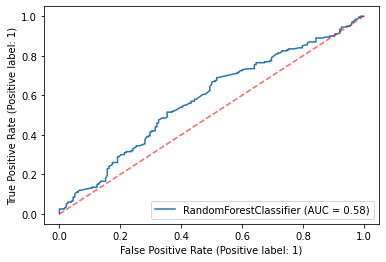

In [150]:
plot_roc_curve(model,X_val, test["Stock_change"])
plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.6)         
plt.show()

# Conclusion

The Prediction Of The NDX 100 Using World Headlines Only is probably insufficient, But it might be a useful feature with other factors that most experts believe to be highly inﬂuential on the stock market situation like Economic growth, market Stability, Related Stocks, etcetera.